In [1]:
import os

import dill

import matplotlib.pyplot as plt
import torch
import pyro
import copy

import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

import torch
import time

import pandas as pd
from torch.utils.data import DataLoader

from chirho.indexed.ops import IndexSet, gather
import seaborn as sns


import pyro
from pyro.infer import Predictive

from chirho.counterfactual.handlers import MultiWorldCounterfactual

# from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel
from cities.modeling.zoning_models.distance_causal_model import DistanceCausalModel
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from pyro.infer.autoguide import AutoDiagonalNormal

from cities.modeling.evaluation import (
    prep_data_for_test,
    test_performance,
)

from cities.modeling.zoning_models.tracts_model import TractsModel

from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do


smoke_test = "CI" in os.environ

# use when testing model health
# smoke_test = True

n_steps = 10 if smoke_test else 1500
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:

census_tracts_data_path = os.path.join(root, "data/minneapolis/processed/census_tracts_dataset.pt")


ct_dataset_read = torch.load(census_tracts_data_path)

ct_loader = DataLoader(
    ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True
)

data = next(iter(ct_loader))

print(data["continuous"].keys())
print(data['categorical'].keys())   

kwargs = {
    "categorical": [
        "year_original",
        "year",
        "census_tract"
    ],
    "continuous": {
      'housing_units',
      'total_value',
      'median_value',
      'mean_limit_original',
      'median_distance',
      'income',
      'segregation_original',
      'white_original',
    },
    'outcome': 'housing_units'
}

subset = select_from_data(data, kwargs)
print(subset["continuous"].keys())
print(subset['continuous']['housing_units'].shape)
print(subset['categorical']['census_tract'].shape)

tracts_model = TractsModel(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)


subset_for_preds = copy.deepcopy(subset)
subset_for_preds['continuous']['housing_units'] = None  

dict_keys(['housing_units', 'housing_units_original', 'income', 'income_original', 'mean_distance', 'mean_distance_original', 'mean_limit', 'mean_limit_original', 'median_distance', 'median_distance_original', 'median_value', 'median_value_original', 'segregation', 'segregation_original', 'total_value', 'total_value_original', 'white', 'white_original'])
dict_keys(['year_original', 'year', 'census_tract'])
dict_keys(['housing_units', 'income', 'mean_limit_original', 'median_distance', 'median_value', 'segregation_original', 'total_value', 'white_original'])
torch.Size([816])
torch.Size([816])


In [3]:
pyro.clear_param_store()

guide_path = os.path.join(root, "data/minneapolis/guides", "tracts_model_guide.pkl")

param_path = os.path.join(root, "data/minneapolis/guides", "tracts_model_params.pth")

with open(guide_path, "rb") as file:
    guide = dill.load(file)

pyro.get_param_store().load(param_path)

predictive = Predictive(
    model=tracts_model, guide=guide, num_samples=num_samples, parallel=True
)

In [4]:
# RUN ONCE TO GENERATE BACKGROUND DATA USED FOR INTERVENTION CONSTRUCTION

# data  = copy.deepcopy(values[['limit_con', 'downtown_yn', 'year', 'distance_to_transit',
#                              'parcel', 'census_tract']])

# data.to_csv(os.path.join(root, "data/minneapolis/processed/census_tract_intervention_required.csv"))

# census_ids = pd.DataFrame({'census_tract':subset['categorical']['census_tract'].numpy(), 
#                            'year':subset['categorical']['year_original'].numpy()})
# census_ids.to_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))

In [5]:
# data = pd.read_csv(os.path.join(root,
#              "data/minneapolis/processed/census_tract_intervention_required.csv"))

# census_ids = pd.read_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))

# display(data.head())
# display(census_ids.head())

In [6]:

def values_intervention(radius_blue, limit_blue, 
                radius_yellow, limit_yellow, reform_year = 2015):
    

    # don't want to load large data multiple times
    
    if not hasattr(values_intervention, "global_census_ids"):   
        values_intervention.global_census_ids = pd.read_csv(os.path.join(root, "data/minneapolis/processed/census_ids.csv"))

        values_intervention.global_data = pd.read_csv(os.path.join(root,
            "data/minneapolis/processed/census_tract_intervention_required.csv"))

        data = values_intervention.global_data
        census_ids = values_intervention.global_census_ids    
        values_intervention.global_data = data[
            (data['census_tract'].isin(census_ids['census_tract'])) & 
            (data['year'].isin(census_ids['year']))]
        
    data = values_intervention.global_data.copy()

    intervention = copy.deepcopy(values_intervention.global_data['limit_con'])
    downtown = data['downtown_yn']
    new_blue = (~downtown) & (data['year'] >= reform_year) & (data["distance_to_transit"] <= radius_blue)
    new_yellow = (
            (~downtown)
            & (data["year"] >= reform_year)
            & (data["distance_to_transit"] > radius_blue)
            & (data["distance_to_transit"] <= radius_yellow)
        )
    new_other = (
        (~downtown) & (data['year'] > reform_year) & (data["distance_to_transit"] > radius_yellow)
    )

    intervention[downtown] = 0.0
    intervention[new_blue] = limit_blue
    intervention[new_yellow] = limit_yellow
    intervention[new_other] = 1.0

    data['intervention'] = intervention 

    return data

#note subsequent runs are much faster
start = time.time()
simple_intervention = values_intervention(300, .5, 700, .7, reform_year = 2015)
end = time.time()
print("Time to run values_intervention 1: ", end - start)
start2 = time.time()
simple_intervention2 = values_intervention(400, .5, 800, .6, reform_year = 2013)
end2 = time.time()

print("Time to run values_intervention 2: ", end2 - start2)


start3 = time.time()
simple_intervention3 = values_intervention(200, .4, 1000, .65, reform_year = 2013)
end3 = time.time()


print("Time to run values_intervention 3: ", end3 - start3)


Time to run values_intervention 1:  0.8220431804656982
Time to run values_intervention 2:  0.06340980529785156
Time to run values_intervention 3:  0.0629878044128418


In [15]:
def tracts_intervention (radius_blue, limit_blue, 
                radius_yellow, limit_yellow, reform_year = 2015):
    
    parcel_interventions = values_intervention(radius_blue, limit_blue,
                        radius_yellow, limit_yellow, reform_year = reform_year)

    aggregate = parcel_interventions[['census_tract', 'year', 'intervention']].groupby(['census_tract', 'year']).mean().reset_index()

    if not hasattr(tracts_intervention, "global_census_ids"):

        tracts_intervention.global_valid_pairs = set(zip(values_intervention.global_census_ids['census_tract'],
                                     values_intervention.global_census_ids['year']))


    print(aggregate['intervention'].shape)

    subaggregate = aggregate[aggregate[['census_tract', 'year']].apply(tuple, axis=1).isin(tracts_intervention.global_valid_pairs)]

    print(subaggregate.shape)
    print(subaggregate.head())

    return torch.tensor(list(subaggregate['intervention']))

    # plt.hist(aggregate['intervention'])
    # plt.show()
    #return torch.tensor(subaggregate['intervention'])

start = time.time()
t_intervention = tracts_intervention(300, .5, 700, .7, reform_year = 2015)
end = time.time()
print("Time to run tracts_intervention 1: ", end - start)

start2 = time.time()
t_intervention2 = tracts_intervention(400, .5, 800, .6, reform_year = 2013)
end2 = time.time()
print("Time to run tracts_intervention 2: ", end2 - start2)


(1122,)
(816, 3)
    census_tract  year  intervention
0    27053000101  2011      1.000000
2    27053000101  2013      1.000000
7    27053000101  2018      0.887542
8    27053000101  2019      0.887856
10   27053000102  2011      1.000000
Time to run tracts_intervention 1:  0.10309982299804688
(1122,)
(816, 3)
    census_tract  year  intervention
0    27053000101  2011      1.000000
2    27053000101  2013      0.841368
7    27053000101  2018      0.839915
8    27053000101  2019      0.840201
10   27053000102  2011      1.000000
Time to run tracts_intervention 2:  0.09249353408813477


In [28]:
print(t_intervention.shape)


with MultiWorldCounterfactual() as mwc:
    with do(actions={"limit": t_intervention}):
        samples = predictive(**subset_for_preds)


print(samples["limit"].shape)
print(samples["housing_units"].shape)


torch.Size([816])
torch.Size([1000, 2, 1, 1, 1, 816])
torch.Size([1000, 2, 1, 1, 1, 816])


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
(1138,)


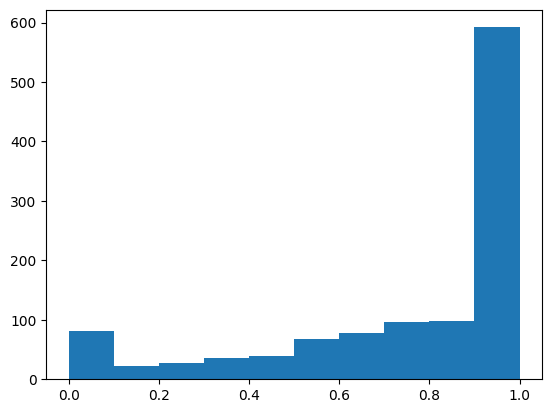

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


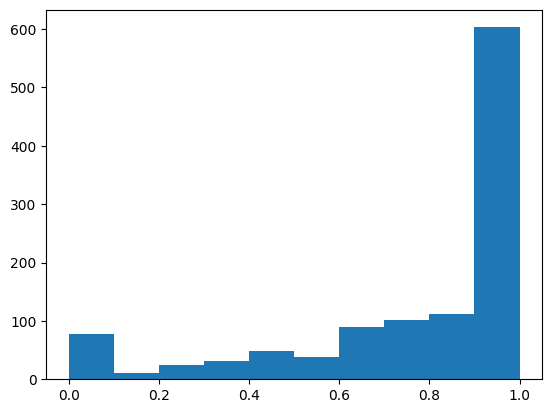

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


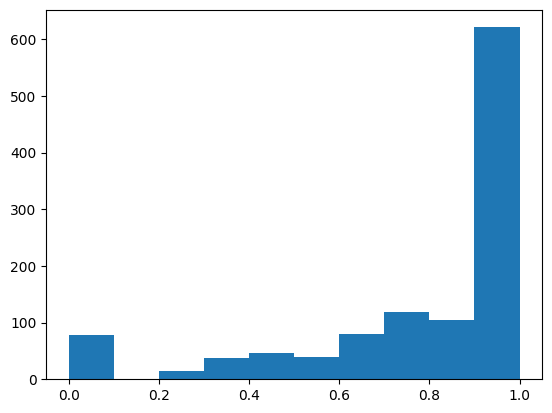

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


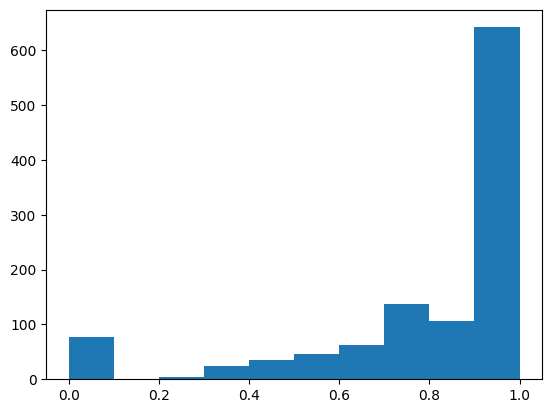

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


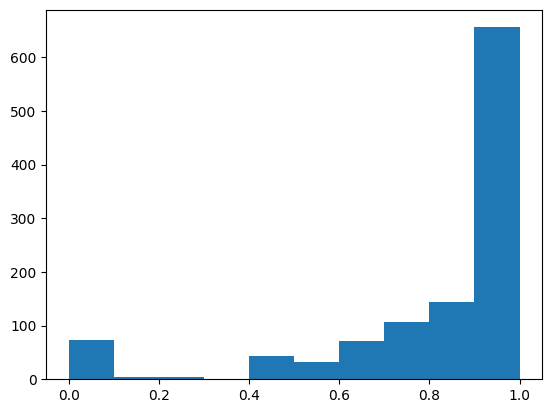

(1138,)


/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


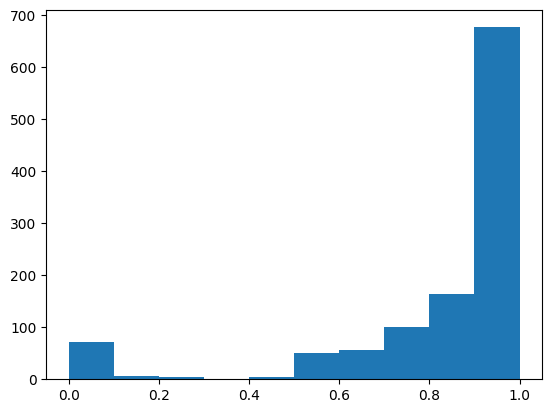

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


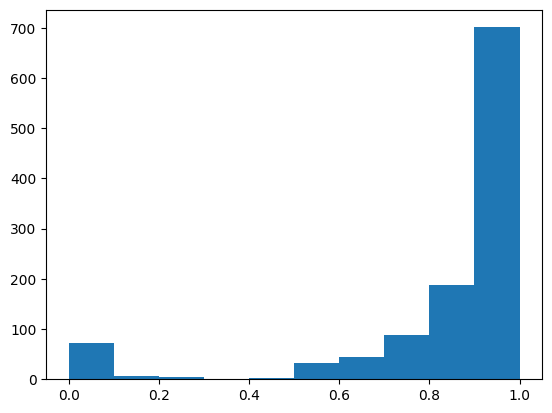

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


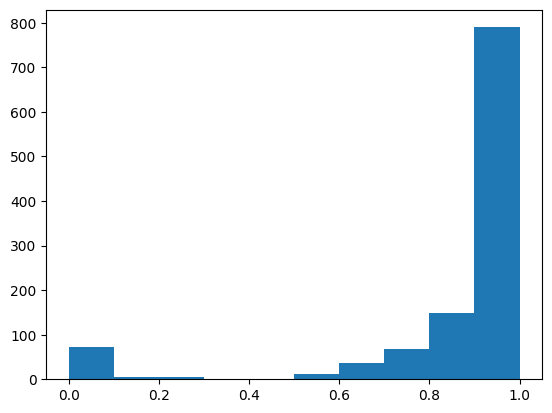

(1138,)


/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


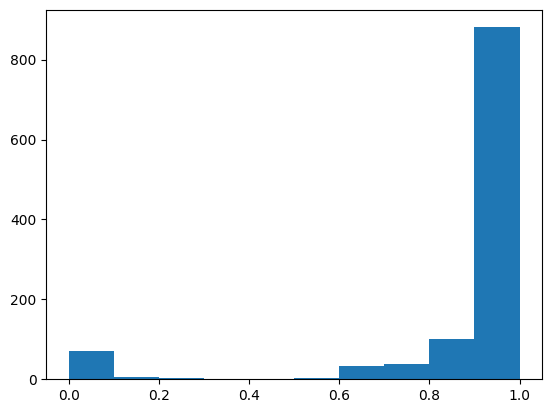

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


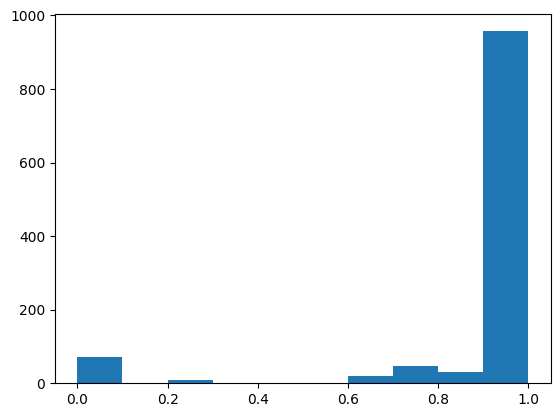

(1138,)


/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


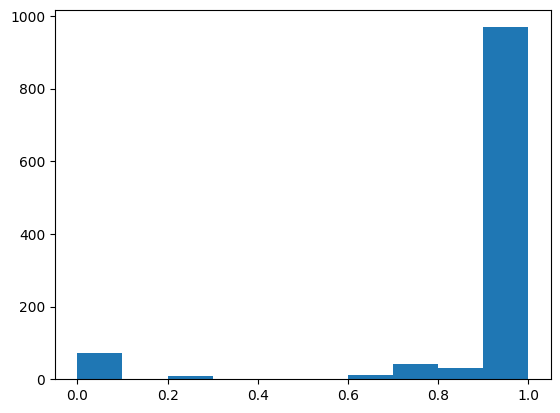

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


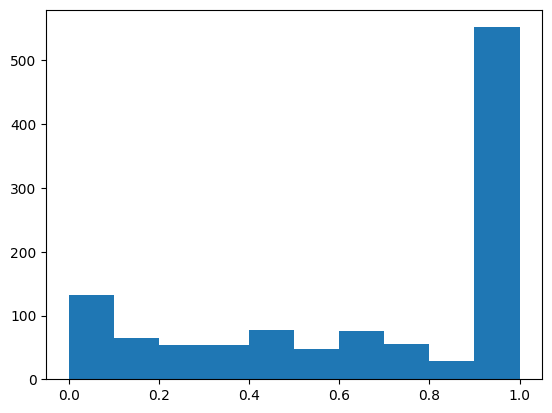

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


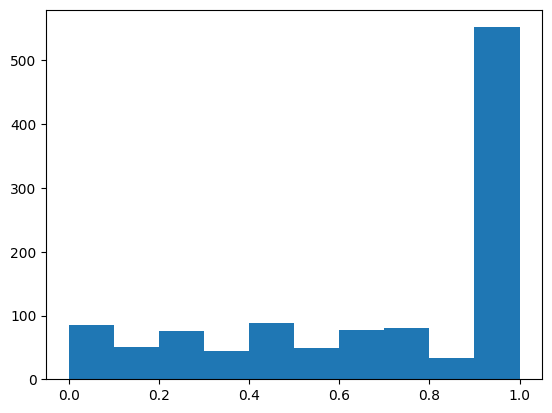

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


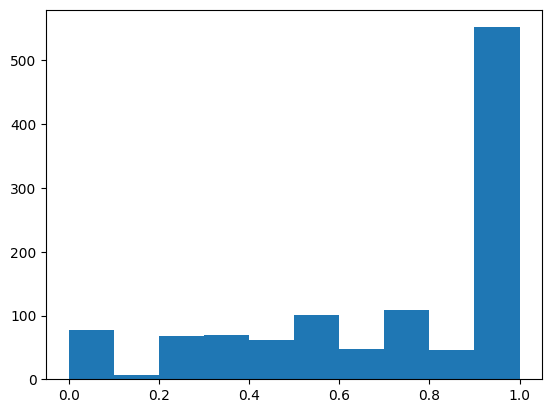

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


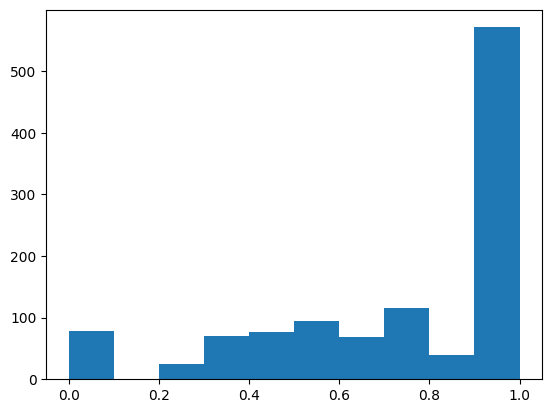

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


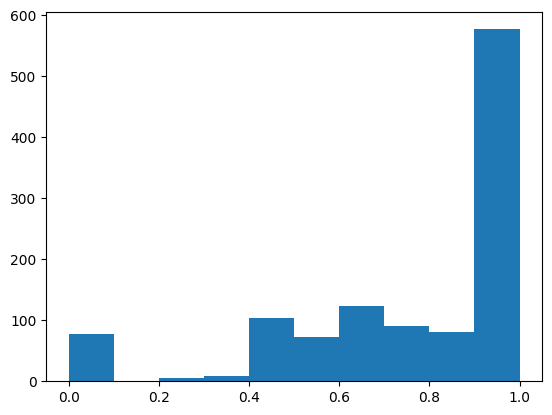

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


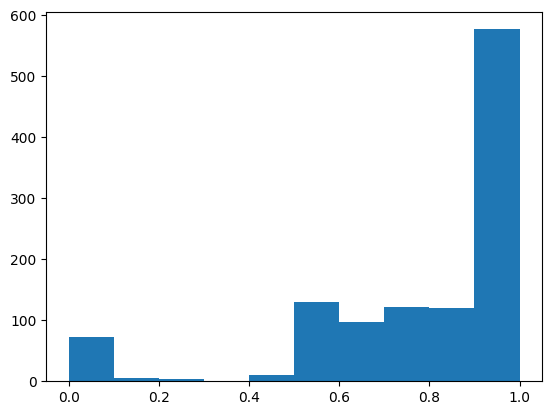

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


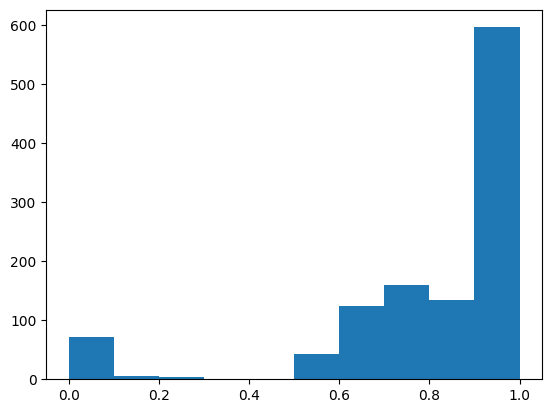

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


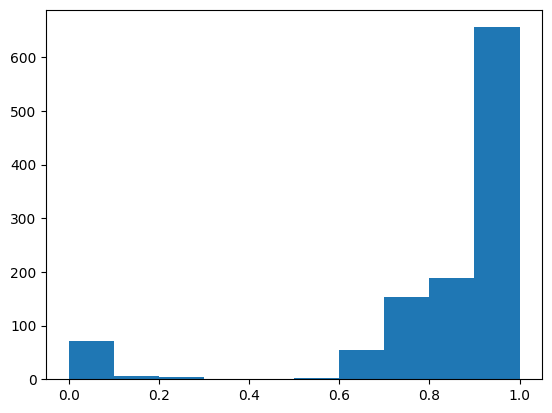

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


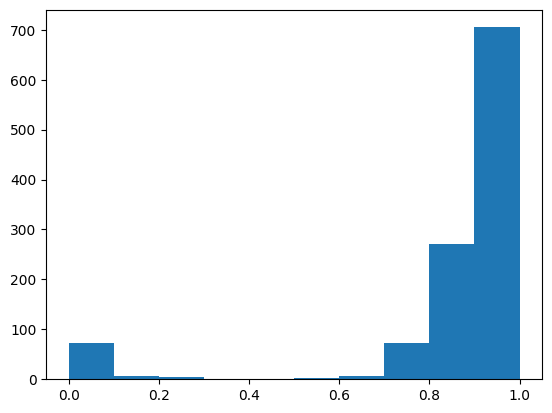

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


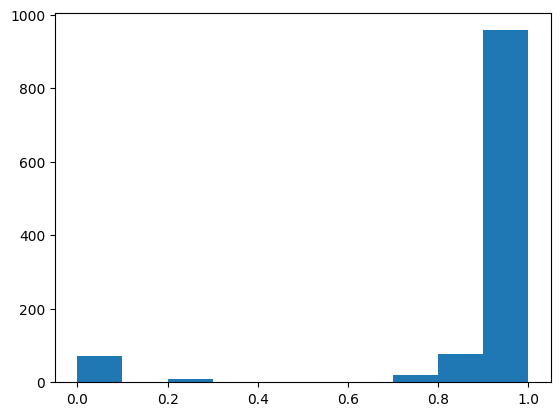

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


(1138,)


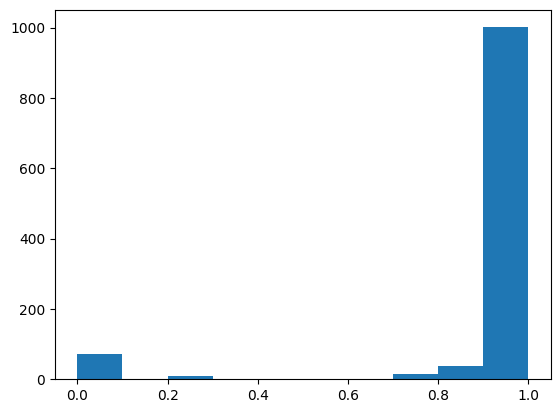

/tmp/ipykernel_4537/3908383575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interventions_list.append(torch.tensor(interventions_values).float())


KeyboardInterrupt: 

In [7]:
distance_interval = 200
distance_max = 2000
# 2600 is almost max in data
dist = np.arange(0, distance_max, distance_interval)
dist = dist.round()  # to avoid small numerical issues

limit_interval = 0.1
lim = np.arange(0, 1.01, limit_interval)
print(lim)
lim = lim.round(decimals=1)
n_lim = len(lim)

start = time.time()
interventions_list = []
interventions_settings_dict = {}
counter = 0
for d_blue in dist:
    for l_blue in lim:
        for d_yellow in dist[dist > d_blue]:  # note the built in restriction
            for l_yellow in lim:
                counter += 1
                interventions_settings_dict[(d_blue, l_blue, d_yellow, l_yellow)] = (
                    counter
                )

                interventions_values = tracts_intervention(
                    radius_blue=d_blue,
                    limit_blue=l_blue,
                    radius_yellow=d_yellow,
                    limit_yellow=l_yellow,
                )

                interventions_list.append(torch.tensor(interventions_values).float())

interventions_tuple = tuple(interventions_list)
end = time.time()


print(counter)
print("Time to generate all interventions: ", end - start)